## Objective: 

### Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2) using PCA and T-SNE.

In [2]:
# Importing the Module

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reading the data from SQLITE
1. We are going to classify our data using the attribute "SCORE" from our dataframe
2. SCORE > 3 is classified as Positive review, 
   SCORE < 3 is classified as Negative review
3. Since SCORE = 3 is Neutral, we will not consider those reviews in our classiication

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('C:/Users/Asha/Machine Learning/17. REAL WORLD PROBLEM PREDICT RATING GIVEN PRODUCT REVIEWS ON AMAZON/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Exploratory Data Analysis

### Data Cleaning: 1. Removing duplicate values

1. It's neccessary to remove the duplicate values from our data points to get unbiased results.
2. In out dataset it is observed that multiple reviews are with the same values for UserId, ProfileName, Score, Time, Summary and Text.
3. When an user gives a review for a particular flavour of some product, the same review is getting added to all the flavours of that product.
4. In order to avoid redundancy, we are eliminating the duplicate values.

In [4]:
#Finding duplicate values in the dataframe

duplicate_data = filtered_data.duplicated(subset={"UserId","ProfileName","Time","Text"})
duplicate_data= filtered_data[duplicate_data]
print("Number of duplicate points in our data",duplicate_data.shape)
print('********************************************************')

#print the duplicate rows
cols = ["UserId","Time"]
print(duplicate_data[cols].head(5))

Number of duplicate points in our data (161641, 10)
********************************************************
              UserId        Time
29    A3HDKO7OW0QNK4  1107820800
530   A3PJZ8TU8FDQ1K  1231718400
2119   AQM74O8Z4FMS0  1127606400
2133   AQM74O8Z4FMS0  1127606400
2146   A5D06XJHDXK75  1190592000


In [5]:
# Displaying duplicate data point

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="A3HDKO7OW0QNK4" AND Time ="1107820800"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
1,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...


In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("Number of final points in our data",final.shape)

Number of final points in our data (364173, 10)


In [8]:
#Checking to see how much % of data still remains
print("% stil remains:",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

% stil remains: 69.25890143662969


### Data Cleaning: 2. Removing values for which HelpfulnessNumerator is greater than HelpfulnessDenominator

1. It has been observed that in the below two rows, the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence removing them from our data

In [9]:
final[final.HelpfulnessNumerator>final.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print("Number of final points in our data",final.shape)

Number of final points in our data (364171, 10)


### Data Cleaning: 3. Removing miscategorized data points

1. The products "B00004CI84" and "B00004CXX9" belong to movie category. Since the product name contains the word "Juice", it has been miscategorized under food.

2. "B0002YW26E" is a Pest control product. Miscategorized as food.

3. The products "6641040" and "2841233731" are CookBooks.

In [11]:
# Removing the miscategorized products from the data

final_data=final[~final.ProductId.isin (['B0002YW26E','B00004CI84','B00004CXX9','6641040','2841233731'])]
print("Number of final points in our data",final_data.shape)

Number of final points in our data (363896, 10)


In [12]:
#How many positive and negative reviews are present in our dataset?
print(final_data['Score'].value_counts())

1    306829
0     57067
Name: Score, dtype: int64


## Text Preprocessing: Stemming, stop-word removal and Lemmatization

In [13]:
# printing some random reviews
sent_238 = final_data['Text'].values[238]
print(sent_238)
print("*"*100)

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_238 = re.sub(r"http\S+", "", sent_238)
print(sent_238)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

print(sent_238)
print("*"*100)
soup = BeautifulSoup(sent_238, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sent_79290 = final_data['Text'].values[79290]
print(sent_79290)
print("*"*100)
sent_79290 = decontracted(sent_79290)
print(sent_79290)

I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can't find them.
****************************************************************************************************
I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can not find them.


In [16]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
print(text)
print("*"*100)
text = re.sub("\S*\d\S*", "", text).strip()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
text = re.sub('[^A-Za-z0-9]+', ' ', text)
print(text)

Why is this when the same product is available for here The Victor and traps are unreal of course total fly genocide Pretty stinky but only right nearby 


In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [143]:
# Combining all the above 
from tqdm import tqdm
preprocessed_reviews = []
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(sno.stem(e.lower()) for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    

100%|█████████████████████████████████████████████████████████████████████████| 363896/363896 [07:09<00:00, 847.07it/s]


In [144]:
preprocessed_reviews[100]

'purchas sever differ brand liver treat best term good size piec small bit littl powder'

In [145]:
final_data['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of review
print(final_data['CleanedText'].values[100])

purchas sever differ brand liver treat best term good size piec small bit littl powder


# Bag of Words (BoW): Unigram

In [22]:
# Since the dataset is inbalanced, we are taking equal no of samples for both positive and negative data

positive_data = final_data[final_data["Score"] == 1].sample(n=57067)
negative_data = final_data[final_data["Score"] == 0].sample(n=57067)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]
print(final_sample.shape)
print(score_sample.shape)

(114134, 11)
(114134,)


In [23]:
#BoW: 
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_sample['CleanedText'].values)
print("The shape of out text BOW vectorizer ",final_counts.get_shape())

The shape of out text BOW vectorizer  (114134, 46607)


In [24]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler 

min_max_scaler = preprocessing.MaxAbsScaler()
x_scaled = min_max_scaler.fit_transform(final_counts)
print(x_scaled.shape)

(114134, 46607)


In [25]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
ctr_features_truncated = svd.fit_transform(x_scaled)

#  2D Visualization using PCA: BoW unigram

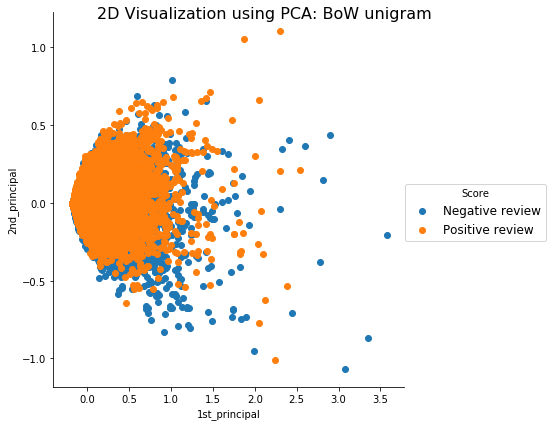

In [26]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()

pca.n_components = 2
pca_data = pca.fit_transform(ctr_features_truncated)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, score_sample)).T

# creating a new data fram which help us in ploting the result data
import seaborn as sn
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

g = sn.FacetGrid(pca_df, hue="Score", size=6, legend_out=True) \
              .map(plt.scatter, '1st_principal', '2nd_principal') \
              .add_legend(labels = new_labels, loc= 5, fontsize=12)  

g.fig.suptitle('2D Visualization using PCA: BoW unigram', fontsize=16)
plt.show()

In [28]:
# Picking the top 2000 points 
positive_data = final_data[final_data["Score"] == 1].sample(n=1000)
negative_data = final_data[final_data["Score"] == 0].sample(n=1000)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]

In [29]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_sample['CleanedText'].values)

In [30]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(final_counts)

In [31]:
standardized_dense_data = standardized_data.todense()

#  2D Visualization using t-SNE: BoW unigram

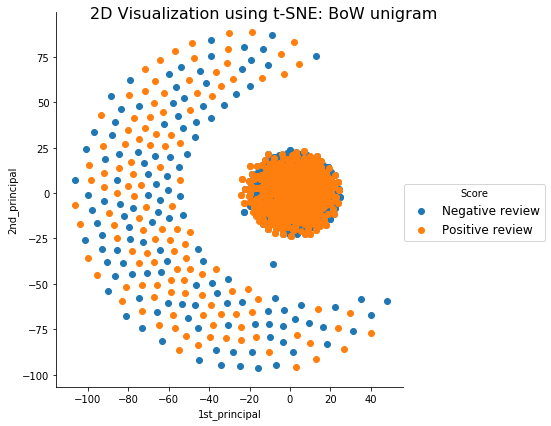

In [33]:
# TSNE

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=1000)
tsne_data = model.fit_transform(standardized_dense_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('1st_principal', '2nd_principal', "Score"))
new_labels = ['Negative review', 'Positive review']


# Ploting the result of tsne
g= sn.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, '1st_principal', '2nd_principal') \
                                          .add_legend(labels = new_labels, loc = 5, fontsize=12)

g.fig.suptitle('2D Visualization using t-SNE: BoW unigram', fontsize=16)
plt.show()

# Bag of Words (BoW): BIGrams


In [34]:
# Since the dataset is inbalanced, we are taking equal no of samples for both positive and negative data

positive_data = final_data[final_data["Score"] == 1].sample(n=57067)
negative_data = final_data[final_data["Score"] == 0].sample(n=57067)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]
print(final_sample.shape)
print(score_sample.shape)

(114134, 11)
(114134,)


In [35]:
#BoW: 
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_sample['CleanedText'].values)
print("The shape of out text BOW vectorizer ",final_bigram_counts.get_shape())

The shape of out text BOW vectorizer  (114134, 1425467)


In [36]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler 

min_max_scaler = preprocessing.MaxAbsScaler()
x_scaled = min_max_scaler.fit_transform(final_bigram_counts)
print(x_scaled.shape)

(114134, 1425467)


In [37]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
ctr_features_truncated = svd.fit_transform(x_scaled)

# 2D Visualization using PCA: BoW bigrams

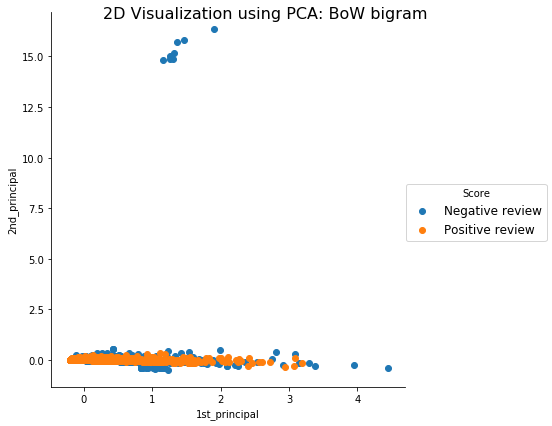

In [38]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()

pca.n_components = 2
pca_data = pca.fit_transform(ctr_features_truncated)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, score_sample)).T

# creating a new data fram which help us in ploting the result data
import seaborn as sn
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

g = sn.FacetGrid(pca_df, hue="Score", size=6, legend_out=True) \
              .map(plt.scatter, '1st_principal', '2nd_principal') \
              .add_legend(labels = new_labels, loc =5, fontsize=12)  

g.fig.suptitle('2D Visualization using PCA: BoW bigram', fontsize=16)
plt.show()

In [39]:
# Picking the top 2000 points 
positive_data = final_data[final_data["Score"] == 1].sample(n=1000)
negative_data = final_data[final_data["Score"] == 0].sample(n=1000)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]

In [40]:
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_sample['CleanedText'].values)
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())

the shape of out text BOW vectorizer  (2000, 67138)


In [41]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(final_bigram_counts)

In [42]:
standardized_dense_data = standardized_data.todense()

# 2D Visualization using t-SNE: BoW bigrams

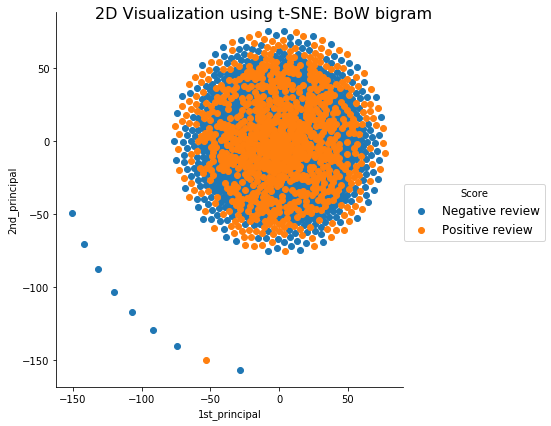

In [43]:
# TSNE Datapoints: 2000

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=1000)
tsne_data = model.fit_transform(standardized_dense_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

# Ploting the result of tsne
g= sn.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, "1st_principal", "2nd_principal")  \
                                          .add_legend(labels = new_labels, loc=5, fontsize=12)

g.fig.suptitle('2D Visualization using t-SNE: BoW bigram', fontsize=16)
plt.show()

# TF-IDF: Unigrams

In [44]:
# Since the dataset is inbalanced, we are taking equal no of samples for both positive and negative data

positive_data = final_data[final_data["Score"] == 1].sample(n=57067)
negative_data = final_data[final_data["Score"] == 0].sample(n=57067)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]
print(final_sample.shape)
print(score_sample.shape)

(114134, 11)
(114134,)


In [45]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final_sample['CleanedText'].values)
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())

the shape of out text TFIDF vectorizer  (114134, 46538)


In [46]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler 

min_max_scaler = preprocessing.MaxAbsScaler()
x_scaled = min_max_scaler.fit_transform(final_tf_idf)
print(x_scaled.shape)

(114134, 46538)


In [47]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
ctr_features_truncated = svd.fit_transform(x_scaled)

# 2D Visualization using PCA: TF-IDF unigram

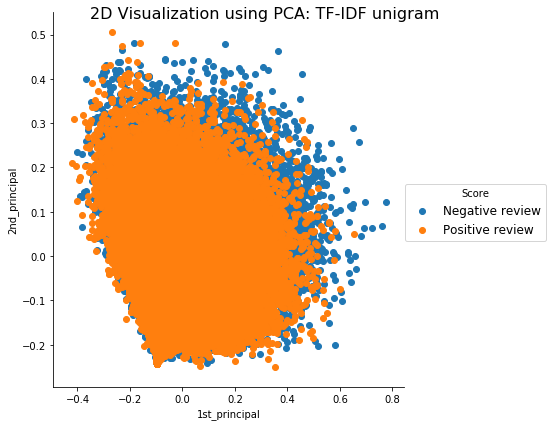

In [48]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()

pca.n_components = 2
pca_data = pca.fit_transform(ctr_features_truncated)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, score_sample)).T

# creating a new data fram which help us in ploting the result data
import seaborn as sn
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

g= sn.FacetGrid(pca_df, hue="Score", size=6, legend_out=True) \
              .map(plt.scatter, '1st_principal', '2nd_principal') \
              .add_legend(labels = new_labels, loc=5, fontsize=12)  
              
g.fig.suptitle('2D Visualization using PCA: TF-IDF unigram', fontsize=16)
plt.show()

In [49]:
# Picking the top 2000 points 
positive_data = final_data[final_data["Score"] == 1].sample(n=1000)
negative_data = final_data[final_data["Score"] == 0].sample(n=1000)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]

In [50]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_sample['CleanedText'].values)
print("the shape of out text BOW vectorizer ",final_counts.get_shape())

the shape of out text BOW vectorizer  (2000, 6698)


In [51]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(final_counts)

In [52]:
standardized_dense_data = standardized_data.todense()

# 2D Visualization using t-SNE: TF-IDF unigram

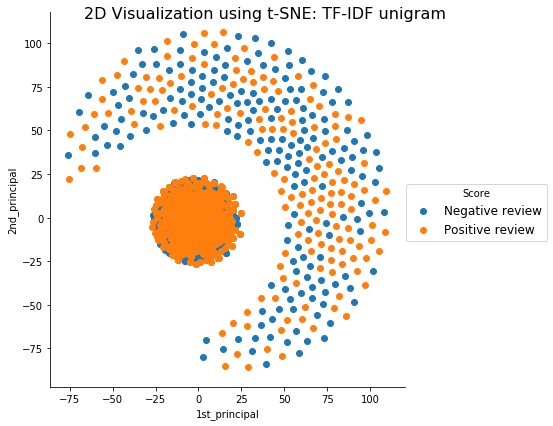

In [53]:
# TSNE Datapoints: 2000

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=1000)
tsne_data = model.fit_transform(standardized_dense_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

# Ploting the result of tsne
g= sn.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, "1st_principal", "2nd_principal")  \
                                          .add_legend(labels = new_labels, loc=5, fontsize=12)

g.fig.suptitle('2D Visualization using t-SNE: TF-IDF unigram', fontsize=16)
plt.show()

# TF-IDF: Bigrams

In [54]:
# Since the dataset is inbalanced, we are taking equal no of samples for both positive and negative data

positive_data = final_data[final_data["Score"] == 1].sample(n=57067)
negative_data = final_data[final_data["Score"] == 0].sample(n=57067)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]
print(final_sample.shape)
print(score_sample.shape)

(114134, 11)
(114134,)


In [55]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_sample['CleanedText'].values)
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())

the shape of out text TFIDF vectorizer  (114134, 1427212)


In [56]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler 

min_max_scaler = preprocessing.MaxAbsScaler()
x_scaled = min_max_scaler.fit_transform(final_tf_idf)
print(x_scaled.shape)

(114134, 1427212)


In [57]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
ctr_features_truncated = svd.fit_transform(x_scaled)

# 2D Visualization using PCA: TF-IDF bigram

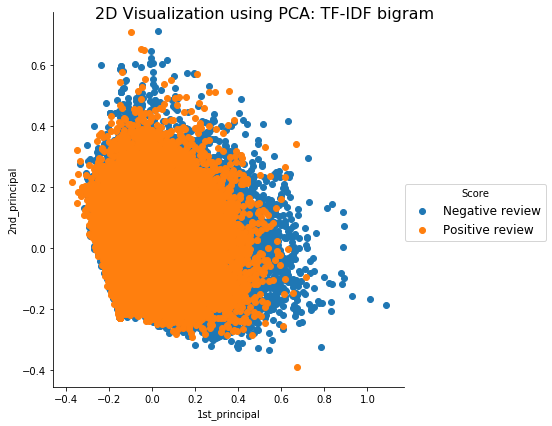

In [58]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()

pca.n_components = 2
pca_data = pca.fit_transform(ctr_features_truncated)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, score_sample)).T

# creating a new data fram which help us in ploting the result data
import seaborn as sn
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

g= sn.FacetGrid(pca_df, hue="Score", size=6, legend_out=True) \
              .map(plt.scatter, '1st_principal', '2nd_principal') \
              .add_legend(labels = new_labels, loc=5, fontsize=12)  
              
g.fig.suptitle('2D Visualization using PCA: TF-IDF bigram', fontsize=16)
plt.show()

In [59]:
# Picking the top 2000 points 
positive_data = final_data[final_data["Score"] == 1].sample(n=1000)
negative_data = final_data[final_data["Score"] == 0].sample(n=1000)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]

In [60]:
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
final_counts = count_vect.fit_transform(final_sample['CleanedText'].values)
print("the shape of out text BOW vectorizer ",final_counts.get_shape())

the shape of out text BOW vectorizer  (2000, 68640)


In [61]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(final_counts)

In [62]:
standardized_dense_data = standardized_data.todense()

# 2D Visualization using t-SNE: TF-IDF bigram

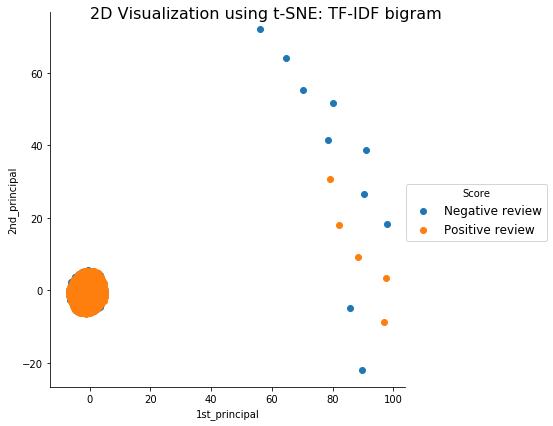

In [63]:
# TSNE Datapoints: 2000

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=1000)
tsne_data = model.fit_transform(standardized_dense_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

# Ploting the result of tsne
g= sn.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, "1st_principal", "2nd_principal")  \
                                          .add_legend(labels = new_labels, loc=5, fontsize=12)

g.fig.suptitle('2D Visualization using t-SNE: TF-IDF bigram', fontsize=16)
plt.show()

# Average Word2vec

In [68]:
# Picking the top 20000 points 
positive_data = final_data[final_data["Score"] == 1].sample(n=10000)
negative_data = final_data[final_data["Score"] == 0].sample(n=10000)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]

In [69]:
# Train the Word2Vec model using text corpus
i=0
list_of_sent=[]
for sent in final_sample['CleanedText'].values:
    list_of_sent.append(sent.split())

In [70]:
print(final_sample['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

like product not best veget tend dri gritti not stir around gluten free diet guess not picki prefer pad thai flavor also fill still order varieti
*****************************************************************
['like', 'product', 'not', 'best', 'veget', 'tend', 'dri', 'gritti', 'not', 'stir', 'around', 'gluten', 'free', 'diet', 'guess', 'not', 'picki', 'prefer', 'pad', 'thai', 'flavor', 'also', 'fill', 'still', 'order', 'varieti']


In [71]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [72]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6572
sample words  ['like', 'product', 'not', 'best', 'veget', 'tend', 'dri', 'gritti', 'stir', 'around', 'gluten', 'free', 'diet', 'guess', 'picki', 'prefer', 'pad', 'thai', 'flavor', 'also', 'fill', 'still', 'order', 'varieti', 'purchas', 'one', 'third', 'time', 'receiv', 'item', 'quick', 'bean', 'appear', 'smell', 'espresso', 'strong', 'use', 'automat', 'machin', 'tast', 'medium', 'slight', 'bitter', 'scent', 'cocoa', 'littl', 'sugar', 'ad', 'sour', 'buy']


In [73]:
w2v_model.wv.most_similar('tasti')

[('satisfi', 0.874884307384491),
 ('yummi', 0.8720912337303162),
 ('crunchi', 0.8463864326477051),
 ('crunch', 0.834140419960022),
 ('chewi', 0.8265701532363892),
 ('crisp', 0.8057186007499695),
 ('dens', 0.7944668531417847),
 ('crave', 0.7908475995063782),
 ('crispi', 0.7852094173431396),
 ('moist', 0.7836296558380127)]

In [74]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:23<00:00, 834.76it/s]


20000
50


In [75]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)

# 2D Visualization using t-SNE: Avg W2V

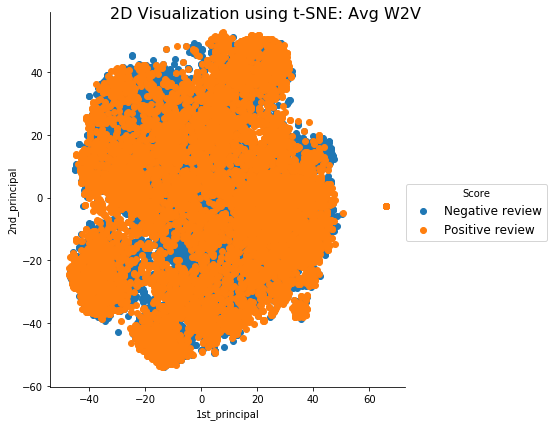

In [76]:
# TSNE Datapoints: 2000

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=1000)
tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

# Ploting the result of tsne
import seaborn as sn
g= sn.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, "1st_principal", "2nd_principal")  \
                                          .add_legend(labels = new_labels, loc=5, fontsize=12)

g.fig.suptitle('2D Visualization using t-SNE: Avg W2V', fontsize=16)
plt.show()

In [80]:
# Train the Word2Vec model using text corpus
# Train using all the data points for visualization using PCA

i=0
list_of_sent=[]
for sent in final_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [81]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
w2v_model.wv.most_similar('tasti')

[('delici', 0.8163961172103882),
 ('yummi', 0.7862197756767273),
 ('tastey', 0.7689963579177856),
 ('good', 0.6910626888275146),
 ('nice', 0.6760581731796265),
 ('hearti', 0.6758647561073303),
 ('satisfi', 0.6615743637084961),
 ('delish', 0.6388089060783386),
 ('nutriti', 0.6323541402816772),
 ('terrif', 0.6267152428627014)]

In [82]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 363896/363896 [16:12<00:00, 374.31it/s]


363896
50


In [83]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
score_sample = final_data["Score"]

# 2D Visualization using PCA: Avg W2V

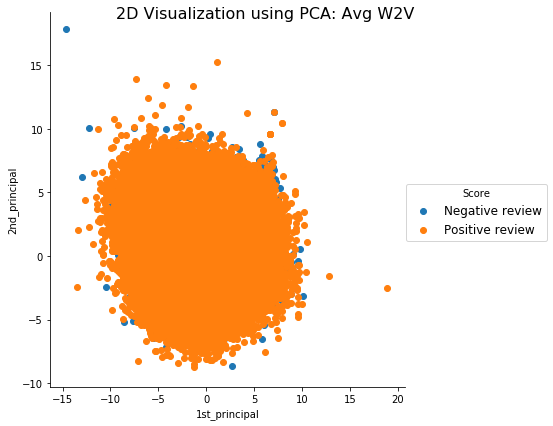

In [84]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()

pca.n_components = 2
pca_data = pca.fit_transform(standardized_data)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, score_sample)).T

# creating a new data fram which help us in ploting the result data
import seaborn as sn
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

g= sn.FacetGrid(pca_df, hue="Score", size=6, legend_out=True) \
              .map(plt.scatter, '1st_principal', '2nd_principal') \
              .add_legend(labels = new_labels, loc=5, fontsize=12)  
              
g.fig.suptitle('2D Visualization using PCA: Avg W2V', fontsize=16)
plt.show()

# TF-IDF Word2vec

In [146]:
# Train the Word2Vec model using text corpus
# Train using all the data points for visualization using PCA

i=0
list_of_sent=[]
for sent in final_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [147]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [148]:
model = TfidfVectorizer(token_pattern= r'\w{1,}')
tf_idf_matrix = model.fit_transform(final_data['CleanedText'].values)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [149]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 363896/363896 [16:13<00:00, 373.91it/s]


In [150]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
score_sample = final_data["Score"]

# 2D Visualization using PCA: TF-IDF W2V

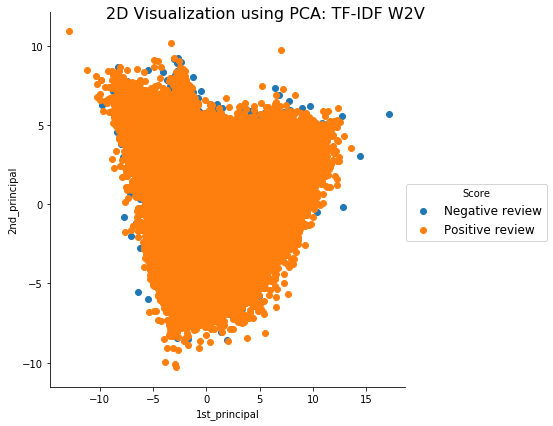

In [151]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()

pca.n_components = 2
pca_data = pca.fit_transform(standardized_data)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, score_sample)).T

# creating a new data fram which help us in ploting the result data
import seaborn as sn
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

g= sn.FacetGrid(pca_df, hue="Score", size=6, legend_out=True) \
              .map(plt.scatter, '1st_principal', '2nd_principal') \
              .add_legend(labels = new_labels, loc=5, fontsize=12)  
              
g.fig.suptitle('2D Visualization using PCA: TF-IDF W2V', fontsize=16)
plt.show()

In [158]:
# Picking the top 2000 points 
positive_data = final_data[final_data["Score"] == 1].sample(n=5000)
negative_data = final_data[final_data["Score"] == 0].sample(n=5000)
final_sample = pd.concat([positive_data, negative_data])
score_sample = final_sample["Score"]

In [159]:
# Train the Word2Vec model using text corpus
# Train using all the data points for visualization using PCA

i=0
list_of_sent=[]
for sent in final_sample['CleanedText'].values:
    list_of_sent.append(sent.split())

In [160]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [161]:
model = TfidfVectorizer(token_pattern= r'\w{1,}')
tf_idf_matrix = model.fit_transform(final_sample['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [162]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 730.27it/s]


In [163]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)

# 2D Visualization using t-SNE: TF-IDF W2V

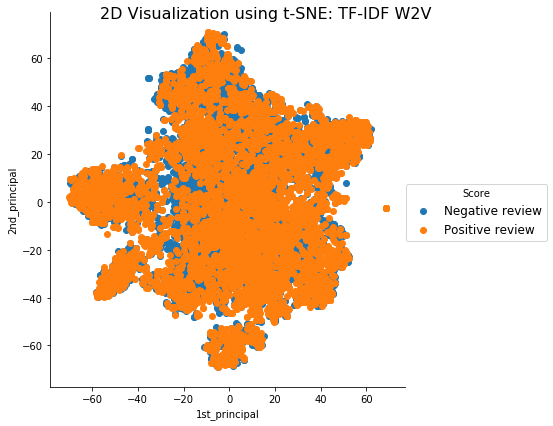

In [164]:
# TSNE Datapoints: 2000

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=1000)
tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("1st_principal", "2nd_principal", "Score"))
new_labels = ['Negative review', 'Positive review']

# Ploting the result of tsne
import seaborn as sn
g= sn.FacetGrid(tsne_df, hue="Score", size=6, legend_out=True).map(plt.scatter, "1st_principal", "2nd_principal")  \
                                          .add_legend(labels = new_labels, loc=5, fontsize=12)

g.fig.suptitle('2D Visualization using t-SNE: TF-IDF W2V', fontsize=16)
plt.show()

# Conclusion: 

1. When comparing all the above plots, 2D visualization using T-SNE BOW and TF-IDF(Unigram) is better compared to others.
2. However none of the above plots linearly seperates both positive and negative points using a plane